#Intro:

Following the groundwork set forth in GateCount_exploratory_fil.ipynb, I'm going to import the datasets processed from that notebook and build upon some of the intuition gained from visuals there to explore other relationships.

In [1]:
# Libraries.
import matplotlib, matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")

# Setup.
% matplotlib inline

# Paths.
path_data = '../../../data/gatecount_%d/'

###Load in Processed Dataset

Running the next cell will load in a processed data set that has the necessary columns for the notebook.

In [2]:
gate_1315=pd.read_csv('../../../data/gatecounts_edit_1315.csv')
gate_1315.head()

,Unnamed: 0,locationid,entries,servicedate,servicetime_fraction,weekday,month
0,0,1002,0,2013-01-01 00:00:00,3.00,1,1
1,1,1002,1,2013-01-01 00:00:00,5.00,1,1
2,2,1002,2,2013-01-01 00:00:00,5.25,1,1
3,3,1002,3,2013-01-01 00:00:00,5.50,1,1
4,4,1002,6,2013-01-01 00:00:00,5.75,1,1


In [3]:
def month_col(date):
    return int(date.split(' ')[0].split('-')[1])

#gate_1315['month']=map(month_col,gate_1315['servicedate'].values)
#gate_1315.head()

###Comments:

mbta_daily is a pre-processed csv that has one row per station per day. The goal is to merge this dataset with a subset of gate_1315 in order to avoid having any absurdly large dataframes causing memory issues.

In [4]:
mbta_daily=pd.read_csv('../../../data/mbta_daily.csv')
mbta_daily.head()

C:\Anaconda\lib\site-packages\pandas\io\parsers.py:1130: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


,locationid,service_day,entries,name,line_1,line_2,lat,lon,service_datetime,fog,...,entries_weeks_ago_1,entries_weeks_ago_2,entries_weeks_ago_3,rain_predict,rain_fall_predict,snow_predict,snow_fall_predict,snow_accum,snow_accum_predict,dist_to_center
0,1002,2013-01-01 00:00:00,1892,Andrew Square,Red,NaN,42.32955,-71.05696,2013-01-01 03:00:00,0,...,NaN,NaN,NaN,0,0,0,0,0,0,3.404767
1,1002,2013-01-02 00:00:00,5134,Andrew Square,Red,NaN,42.32955,-71.05696,2013-01-02 04:45:00,0,...,NaN,NaN,NaN,0,0,0,0,0,0,3.404767
2,1002,2013-01-03 00:00:00,5733,Andrew Square,Red,NaN,42.32955,-71.05696,2013-01-03 05:00:00,0,...,NaN,NaN,NaN,0,0,0,0,0,0,3.404767
3,1002,2013-01-04 00:00:00,6125,Andrew Square,Red,NaN,42.32955,-71.05696,2013-01-04 05:00:00,0,...,NaN,NaN,NaN,0,0,0,0,0,0,3.404767
4,1002,2013-01-05 00:00:00,3410,Andrew Square,Red,NaN,42.32955,-71.05696,2013-01-05 04:15:00,0,...,NaN,NaN,NaN,0,0,1,0,0,0,3.404767


In [9]:
mbta_daily['month']=map(month_col,mbta_daily['service_day'].values)

mbta_daily=mbta_daily[['locationid','service_day','snow','snow_fall']]
mbta_daily.head()

,locationid,service_day,snow,snow_fall
0,1002,2013-01-01 00:00:00,0,0
1,1002,2013-01-02 00:00:00,0,0
2,1002,2013-01-03 00:00:00,0,0
3,1002,2013-01-04 00:00:00,0,0
4,1002,2013-01-05 00:00:00,0,0


In [10]:
## Now we have weather data for each day

snow_daily=mbta_daily.groupby('service_day').agg(np.mean).reset_index()
snow_daily=snow_daily[['service_day','snow','snow_fall']]
snow_daily.head()

,service_day,snow,snow_fall
0,2013-01-01 00:00:00,0,0
1,2013-01-02 00:00:00,0,0
2,2013-01-03 00:00:00,0,0
3,2013-01-04 00:00:00,0,0
4,2013-01-05 00:00:00,0,0


###Import stations info

Bring in a csv that contains the line and group number for each station id. Idea: see if stations that are in the same group behave similarly in snowy conditions

In [11]:
station_info=pd.read_csv('../../../data/Stations_clean.csv')

In [12]:
group_0_ids=list(station_info[station_info['grouping']==0]['stationid'].values)
group_1_ids=list(station_info[station_info['grouping']==1]['stationid'].values)
group_2_ids=list(station_info[station_info['grouping']==2]['stationid'].values)

station_info.head()


,Unnamed: 0,stationid,name,line_temp,grouping,dist_to_center
0,0,1002,Andrew Square,Red,2,3.404767
1,1,1004,JFK/U Mass,Red,0,4.328881
2,2,1005,North Quincy,Red,1,9.777437
3,3,1006,Wollaston,Red,1,10.976943
4,4,1007,Quincy Center,Red,1,12.909591


###Snow_change function

Below is a function that will do a lot of the heavy lifting for this notebook. Given a station_id and a time window, along with a few other parameters to tune output, snow_change() calculates the change in ridership for a given amount of snowfall.

For example, let's assume the very simplified case where 10 riders enter Kenmore station on a day with no snow, also assuming the day is in October-March in order to reduce any seasonal trends. This will be our reference value. Suppose we observed a day with 2 inches of snowfall and only 8 riders entered Kenmore station over the whole day. This will plot a point at coordinates (2, .8) since a day with 2 inches of snow had 80% of the usual ridership.

In [13]:
'''
Fit a linear function of snowfall on the entries for a given station.

begin/end_time: set window of interest for workday. Set to normal AM rush hour

percent: T/F to show y axis as percent of avg entry w/o snow. Otherwise, raw numbers are used and y-axis will
 suffer if this function is used to plot linear fit on multiple stations whose entries differ by large amounts
 
plot: T/F whether or not to plot

plot_type: both, line, or scatter for what to display
***
returns: parameters of line of best fit
'''

def snow_change(station_id,begin_time=6.5,end_time=9.5,percent=False,plot_type='both',plot=True):
    #get subset of station
    station_records=gate_1315[gate_1315['locationid']==station_id]
    
    #want to subset the dataframe to only include months in which there may be snow
    # don't want the seasonal trends of Summer, Spring, early Fall to skew my values for when there 
    # is no snow
    station_records=station_records[(station_records['month']>=10) |(station_records['month']<=3)]
    station_records=station_records[station_records['weekday']<5]
    station_records=station_records[(station_records['servicetime_fraction']<=end_time) & (station_records['servicetime_fraction']>=begin_time) ]
    
    # Now merge in the weather data
    station_records=station_records.merge(snow_daily,left_on='servicedate',right_on='service_day')
    #return station_records
    if(percent):
        #get subset of snow records
        no_snow=station_records[station_records['snow']==False]
        mean_ridership=np.mean(no_snow[['servicedate','entries']].groupby('servicedate').agg(np.sum)['entries'])
        #print mean_ridership
        
    station_records=station_records[station_records['snow']==True]   
    
    station_records=station_records[station_records['snow_fall']<=20]
    station_grouping=station_records[['servicetime_fraction','servicedate','entries','snow_fall']].groupby('servicedate')
    
    snowfall_vec=station_grouping.agg(np.median)['snow_fall']
    entries_vec=station_grouping.agg(np.sum)['entries']
    
    if(percent):
        p = np.polyfit(snowfall_vec.values,entries_vec.values*1./mean_ridership,1)
    else:
        p = np.polyfit(snowfall_vec.values,entries_vec.values,1)

    x_vals=np.linspace(0,25,len(snowfall_vec.values))
    if plot:
        if (plot_type=='scatter')| (plot_type=='both'):
            if percent:
                plt.scatter(snowfall_vec.values,entries_vec.values*1./mean_ridership,alpha=0.3,color='r')
            else:
                plt.scatter(snowfall_vec.values,entries_vec.values,alpha=0.3,color='r')
        if (plot_type=='line')| (plot_type=='both'):
            plt.plot(x_vals,p[0]*x_vals+p[1],alpha=0.75,label="station: "+str(station_id)) # A red solid line

        plt.xlabel('Inches of Snow')
        plt.ylabel('Entries')
        plt.title('Snowfall vs Entries for station: '+str(station_id))
    #for day in station_grouping:
        
    return [snowfall_vec.values,p,(entries_vec.values*1./mean_ridership)]



###Comment:

I removed the days with more than 20 inches of snow because they were very few yet significantly affected the linear models fit to the data. Atypical amounts of snowfall, like we experienced during January and February of 2015, clearly affect both ridership and performance of the MBTA, but we may not want to build a model to encompass those events at the expense of accurately modeling more typical amounts of snowfall.

##Effect of Snowfall on AM Rush Hour Ridership

Below, we see a series of points where the x axis represents the amount of snow on a given day and the y-axis is the ratio of total ridership on that day to the ridership of at that station on days without snow. Presenting the data in this way helps show the effect of snowfall across stations without worrying about the difference in volume between stations. Also plotted is the linear model fit using least squares. 

Note: Keep in mind that we are only considering the AM rush hour period of 6:30 a.m. to 9:30 p.m. This analysis can easily be extended to the whole day, but we thought this was an important part of the day that deserved its own focus.

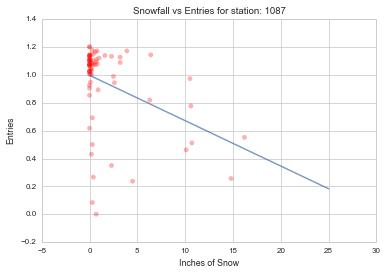

In [107]:
c=snow_change(1087,percent=True,plot_type='both') 


We can perform the analysis above on all stations to get an idea how the whole MBTA system is affected by snowfall

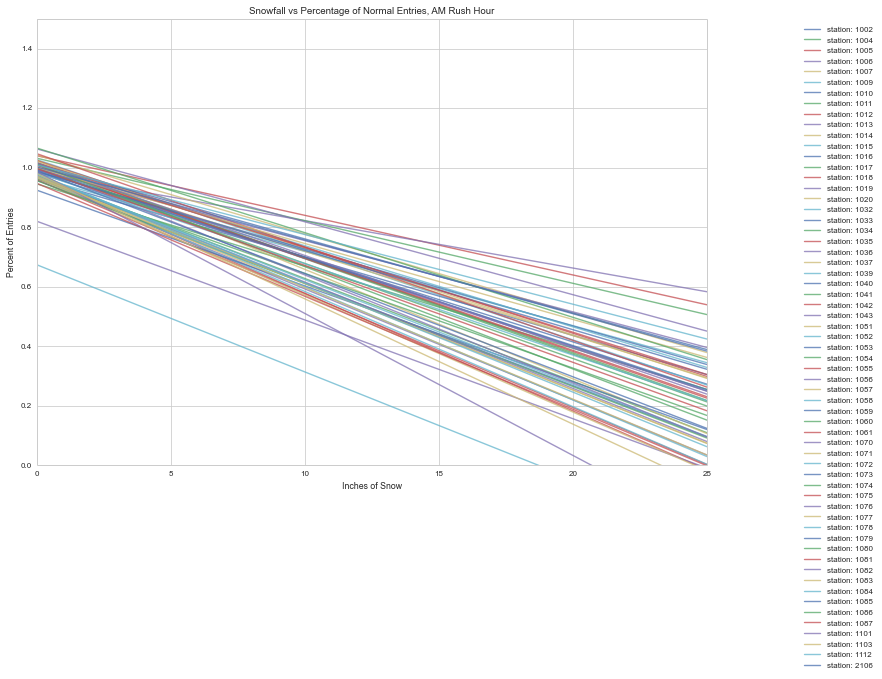

In [105]:
plt.figure(figsize=(12,8))

models=[]
for station in list(station_info['stationid'].values):
    #print station
    t=snow_change(station,percent=True,plot_type='line')
    models.append(t[1])
    plt.xlabel('Inches of Snow')
    plt.ylabel('Percent of Entries')
    plt.ylim([0,1.5])
    #plt.title('Snowfall vs Entriesw/o Snow for station: '+str(station_id))
    
plt.title('Snowfall vs Percentage of Normal Entries, AM Rush Hour')
plt.legend(bbox_to_anchor=(1.1, .9),bbox_transform=plt.gcf().transFigure)
plt.show()

###Comment:
In order to reduce the clutter on the plot, I've averaged the models below and included a shaded region representing one standard deviation from the mean model value at each point.

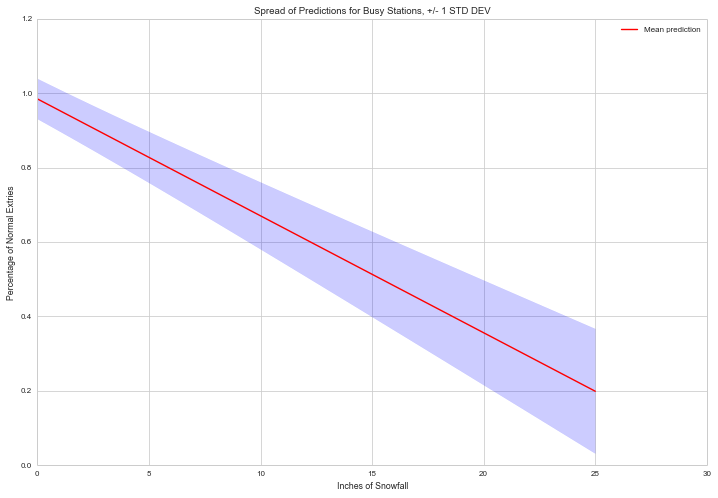

In [106]:
x_values=np.linspace(0,25,100)

pred=np.zeros([len(models),len(x_values)])
plt.figure(figsize=(12,8))

for mod in range(len(models)):
    
    pred[mod]=models[mod][0]*x_values+models[mod][1]
    
# Group the predictions according to their x_value
pred_per_x=pred.transpose()

mean_pred=np.mean(pred_per_x,axis=1)
std_pred=np.std(pred_per_x,axis=1)

upper=(mean_pred + std_pred)
lower=(mean_pred - std_pred)

plt.plot( x_values, mean_pred, color='r', label='Mean prediction')
plt.fill_between(x_values, upper, lower, color='b', alpha=.2,label='1 std dev')
plt.xlabel('Inches of Snowfall')
plt.ylabel('Percentage of Normal Extries')
plt.title('Spread of Predictions for Busy Stations, +/- 1 STD DEV')
plt.legend()
plt.show()



###Comments:

It's clear that snowfall has an adverse effect on ridership, but by aggregating all of the stations into one plot, we lose any intuition about how ridership changes at different stations. Consider the question, "Does snow affect stations outside the city differently than those close to downtown?" We lose the ability to answer this question when we aggregate stations. Analysis in the introductory notebook showed that stations exhibit different ridership patterns and different volumes of ridership so a broad-reaching analysis like the one above may not be the best to draw actionable conclusions.

##Snowfall based on clustering stations

The following analysis follows from the station grouping derived in the notebook concerning the identification of 'similar stations'. The analysis suggested that stations usually have ridership patterns similar to other stations who are equally as far from Boston City Hall. The station groupings are below..

![grouping](Similar Stations\group_text.png)



###Group 0 stations, Closer to City Hall

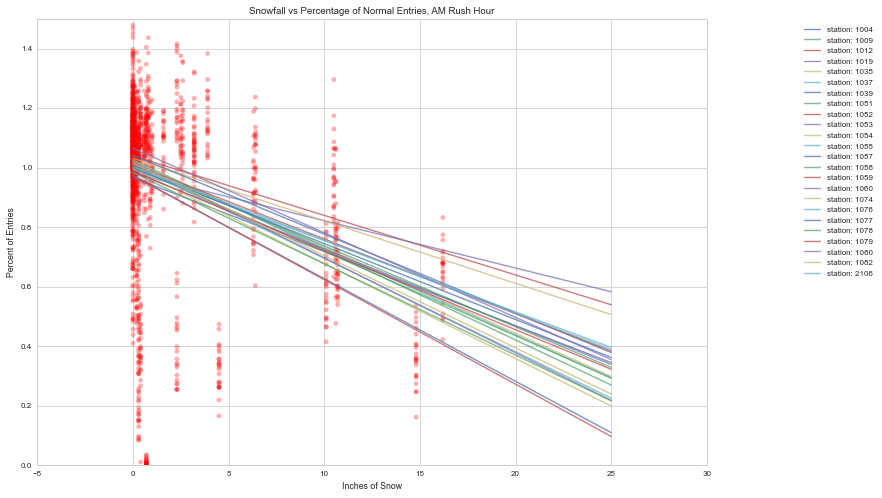

In [108]:

models=[]
snowfall=list([])
ridership=list([])
plt.figure(figsize=(12,8))

for station in group_0_ids:
    #print station
    t=snow_change(station,percent=True,plot_type='both')
    models.append(t[1])
    snowfall.append(t[0])
    ridership.append(t[2])
    plt.xlabel('Inches of Snow')
    plt.ylabel('Percent of Entries')
    plt.ylim([0,1.5])
plt.title('Snowfall vs Percentage of Normal Entries, AM Rush Hour')
plt.legend(bbox_to_anchor=(1.1, .9),bbox_transform=plt.gcf().transFigure)
plt.show()


In [26]:
#create a dict to hold the slopes from each model, separated into my grouping
slopes={0:[],1:[],2:[]}

#Comments:

Look at the output of the plot below. We see that for stations near Boston City Hall, the linear model predicts that for 5 inches of snowfall, stations in this grouping will have 86.7% of the average ridership. Each point also has error bars corresponding to the variance in ridership for points with the same amount of snowfall.

Percentage of ridership for 5.05050505051 inches of snow: 0.867638080995


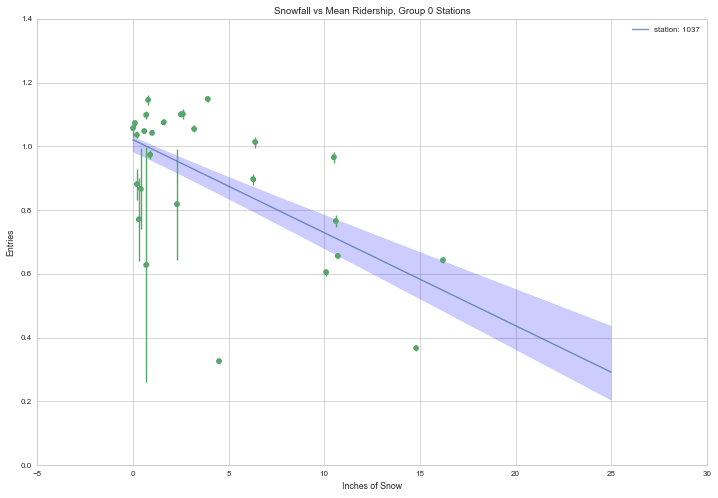

In [110]:

def temp_mean(x):
        return np.mean(x)
def temp_var(x):
    return np.var(x)

snowfall_vector=list([])
ride_vector=list([])
plt.figure(figsize=(12,8))

#using downtown and state st, high correlation
for stat in group_0_ids:
    if(stat==1037):
        plot=True
    else:
        plot=False
    
    c=snow_change(stat,percent=True,plot_type='line',plot=plot)

    snowfall_vector+=list(c[0])
    ride_vector+=list(c[2])

d=pd.DataFrame(zip(snowfall_vector,ride_vector),columns=['snowfall','ridership'])
    
summary=d.groupby('snowfall').agg([temp_mean,temp_var,len])

## Remove snowdays

plt.title('Snowfall vs Mean Ridership, Group 0 Stations')
plt.scatter(summary.index,summary['ridership']['temp_mean'])
plt.errorbar(summary.index,summary['ridership']['temp_mean'],yerr=summary['ridership']['temp_var'],fmt='o')

plt.fill_between(x_values, upper, lower, color='b', alpha=.2,label='1 std dev')
plt.legend()

means=summary['ridership']['temp_mean']
var=summary['ridership']['temp_var']
num=summary['ridership']['len']

print 'Percentage of ridership for '+str(x_values[20])+' inches of snow: '+str(mean_pred[20])

###Group 1 Stations, Far Away from City Hall

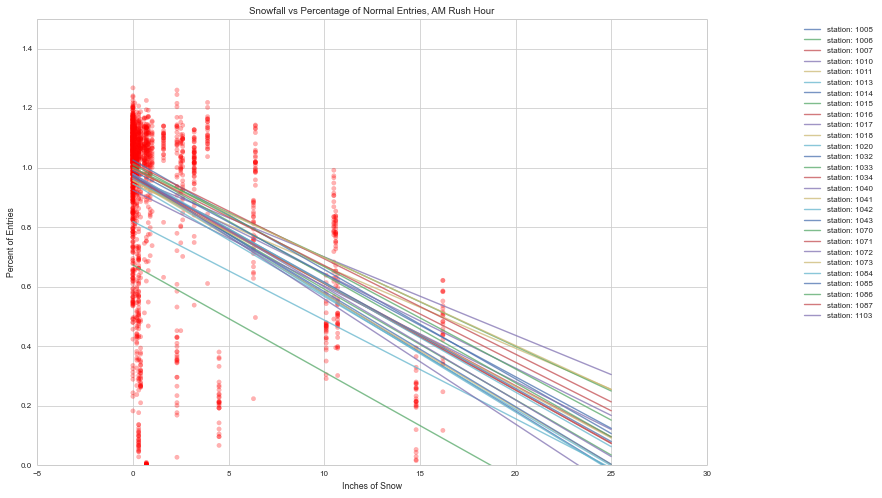

In [77]:
models=[]
snowfall=list([])
ridership=list([])
plt.figure(figsize=(12,8))

for station in group_1_ids:
    #print station
    t=snow_change(station,percent=True,plot_type='both')
    models.append(t[1])
    snowfall.append(t[0])
    ridership.append(t[2])
    plt.xlabel('Inches of Snow')
    plt.ylabel('Percent of Entries')
    plt.ylim([0,1.5])
    
plt.title('Snowfall vs Percentage of Normal Entries, AM Rush Hour')
plt.legend(bbox_to_anchor=(1.1, .9),bbox_transform=plt.gcf().transFigure)
plt.show()


Percentage of ridership for 5.05050505051 inches of snow: 0.782716373395


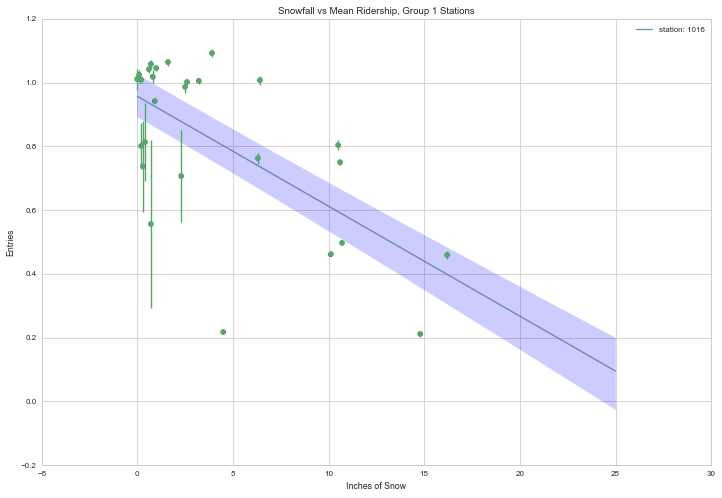

In [90]:

snowfall_vector=list([])
ride_vector=list([])
plt.figure(figsize=(12,8))

#using downtown and state st, high correlation
for stat in group_1_ids:
    if(stat==1016):
        plot=True
    else:
        plot=False
    
    c=snow_change(stat,percent=True,plot_type='line',plot=plot)

    snowfall_vector+=list(c[0])
    ride_vector+=list(c[2])

d=pd.DataFrame(zip(snowfall_vector,ride_vector),columns=['snowfall','ridership'])
    
summary=d.groupby('snowfall').agg([temp_mean,temp_var,len])

## Remove snowdays

plt.title('Snowfall vs Mean Ridership, Group 1 Stations')
plt.scatter(summary.index,summary['ridership']['temp_mean'])
plt.errorbar(summary.index,summary['ridership']['temp_mean'],yerr=summary['ridership']['temp_var'],fmt='o')

plt.fill_between(x_values, upper, lower, color='b', alpha=.2,label='1 std dev')
plt.legend()

means=summary['ridership']['temp_mean']
var=summary['ridership']['temp_var']
num=summary['ridership']['len']

print 'Percentage of ridership for '+str(x_values[20])+' inches of snow: '+str(mean_pred[20])

###Comments:

Note that the mean prediction of ridership for 5 inches of snow for these stations further away from Boston City Hall is 78.27%, approximately 8% less than what we saw for the stations in the heart of the city. This early analysis suggests that snowfall causes a larger drop in ridership for these stations that may be the origin to commuters further from the city center.

###Group 2 Stations, Middle-distance from the city

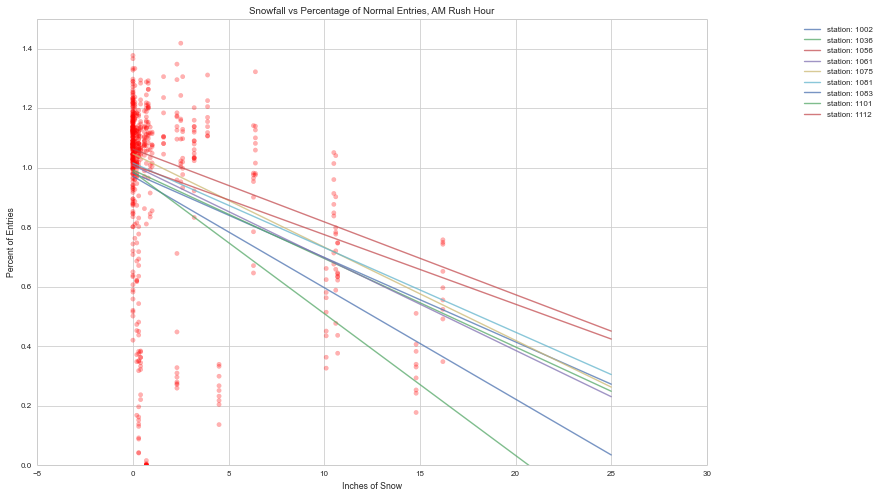

In [91]:
models=[]
snowfall=[]
ridership=[]
plt.figure(figsize=(12,8))

for station in group_2_ids:
    #print station
    t=snow_change(station,percent=True,plot_type='both')
    models.append(t[1])
    snowfall.append(t[0])
    ridership.append(t[2])
    plt.xlabel('Inches of Snow')
    plt.ylabel('Percent of Entries')
    plt.ylim([0,1.5])
    
plt.title('Snowfall vs Percentage of Normal Entries, AM Rush Hour')
plt.legend(bbox_to_anchor=(1.1, .9),bbox_transform=plt.gcf().transFigure)
plt.show()


Percentage of ridership for 5.05050505051 inches of snow: 0.849685189409


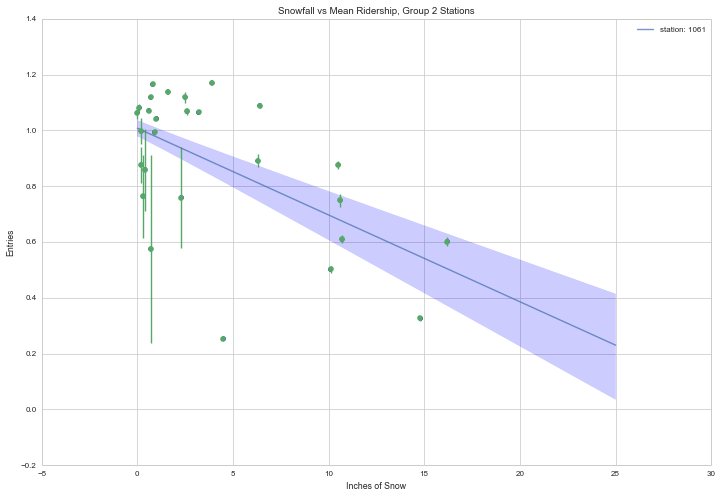

In [95]:


snowfall_vector=list([])
ride_vector=list([])
plt.figure(figsize=(12,8))

#using downtown and state st, high correlation
for stat in group_2_ids:
    if(stat==1061):
        plot=True
    else:
        plot=False
    
    c=snow_change(stat,percent=True,plot_type='line',plot=plot)

    snowfall_vector+=list(c[0])
    ride_vector+=list(c[2])

d=pd.DataFrame(zip(snowfall_vector,ride_vector),columns=['snowfall','ridership'])
    
summary=d.groupby('snowfall').agg([temp_mean,temp_var,len])

## Remove snowdays

plt.title('Snowfall vs Mean Ridership, Group 2 Stations')
plt.scatter(summary.index,summary['ridership']['temp_mean'])
plt.errorbar(summary.index,summary['ridership']['temp_mean'],yerr=summary['ridership']['temp_var'],fmt='o')

plt.fill_between(x_values, upper, lower, color='b', alpha=.2,label='1 std dev')
plt.legend()

means=summary['ridership']['temp_mean']
var=summary['ridership']['temp_var']
num=summary['ridership']['len']

print 'Percentage of ridership for '+str(x_values[20])+' inches of snow: '+str(mean_pred[20])

###Comment:
The mean predicted value for 5 inches of snow for Group 2 stations is 84.96% which is more in line with what we saw for Group 0 stations which are very near City Hall.


###Investigating Slopes of Models

The plots above provide valuable insight into how snowfal affects the AM rush hour for our grouping of the stations. However, we lose any information about the distribution of the linear models fit within each grouping upon averaging them into one model for the whole group. Below we used box plots to examine the distribution snowfall coefficients within each grouping. In non-statistical terms, the plots show the distribution of how snow affects all stations within a group. Lower values suggest that each additional inch of snow leads to less entrances.

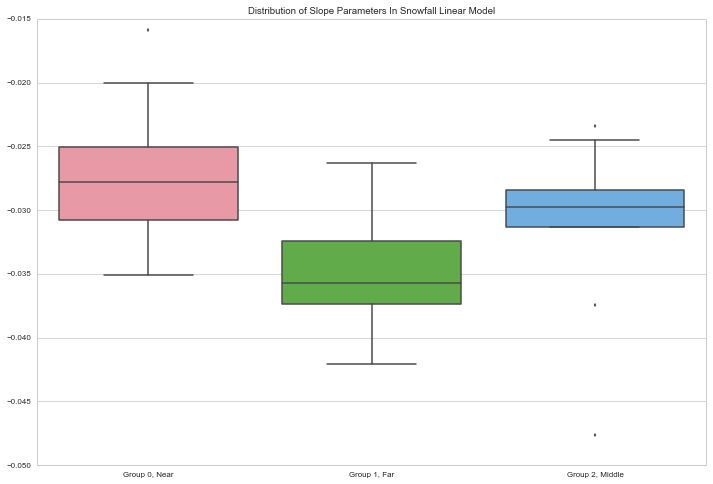

In [46]:
plt.figure(figsize=(12,8))
sns.boxplot([slopes[0],slopes[1],slopes[2]],names=["Group 0, Near",'Group 1, Far','Group 2, Middle'])
plt.title('Distribution of Slope Parameters In Snowfall Linear Model')
plt.show()

###Comments:

As seen in the box plots above, the coefficients on snowfall are significantly lower for the Group 1 stations (those further away from the city). In other words, for the stations further from the city, each unit of snowfall reduces ridership by a greater amount than it does for stations closer to the city.

##Fitting a Higher-Order model

In [182]:
import scipy.optimize as optimization


###Group 0 Stations (Close to City Hall)

False
False


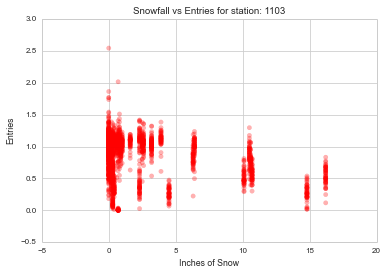

In [141]:
xs1=list([])
ys1=list([])
xs2=list([])
ys2=list([])

for station in group_0_ids:
    temp=snow_change(station,percent=True,plot=True,plot_type='scatter')
    
    #if(len(ys)==0):
    xs1=xs1+list(temp[0])
    ys1=ys1+list(temp[2])
    
for station in group_1_ids:
    temp=snow_change(station,percent=True,plot=True,plot_type='scatter')
    
    #if(len(ys)==0):
    xs2=xs2+list(temp[0])
    ys2=ys2+list(temp[2])
    
print xs1==xs2
print ys1==ys2

24
Parameters: [  1.00461614e+00  -2.75481961e-02   1.00251259e-03  -7.46342116e-05]


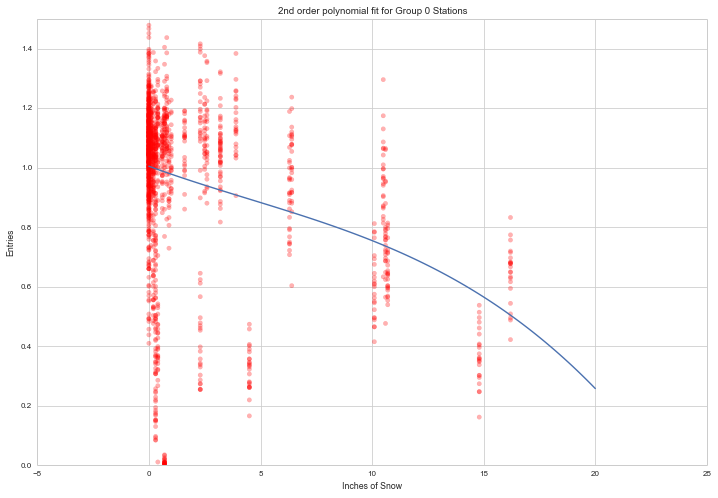

Percentage of ridership for 4.0404040404 inches of snow: 0.904753377512


In [187]:

xs=list([])
ys=list([])
plt.figure(figsize=(12,8))
plt.ylim([0,1.5])

print len(group_0_ids)
for station in group_0_ids:
    temp=snow_change(station,percent=True,plot=True,plot_type='scatter')
    
    #if(len(ys)==0):
    xs=xs+list(temp[0])
    ys=ys+list(temp[2])


def q_func(x,a,b,c,d):
    return a + b*x + c*x*x + d*x**3

x0=np.array([1.2,0,0,0])

fitted_params=optimization.curve_fit(q_func, xs, ys, x0)
print 'Parameters: '+str(fitted_params[0])
#fitted_params[0][0]

x_values=np.linspace(0,20,100)
y_values=q_func(x_values,fitted_params[0][0],fitted_params[0][1],fitted_params[0][2],fitted_params[0][3])

plt.plot(x_values,y_values)
plt.title('3rd order polynomial fit for Group 0 Stations')
plt.show()

print 'Percentage of ridership for '+str(x_values[20])+' inches of snow: '+str(y_values[20])

###Group 1 Stations (Further Away)

28
Parameters: [  9.58705645e-01  -4.03664592e-02   2.20213111e-03  -1.32177022e-04]


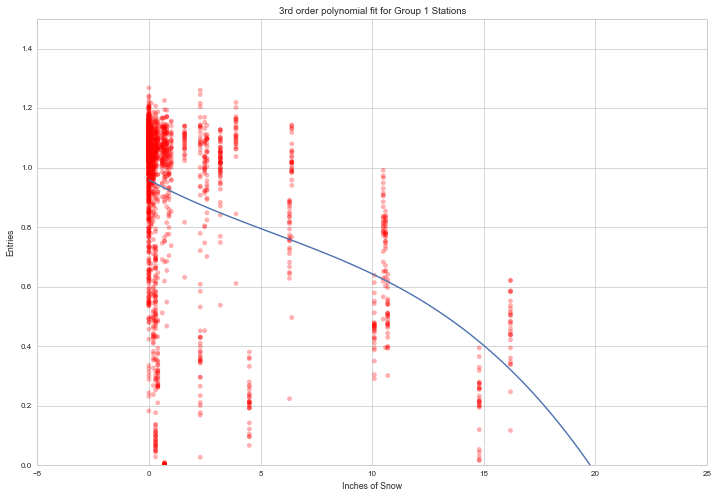

Percentage of ridership for 4.0404040404 inches of snow: 0.822840061429


In [188]:

xs=list([])
ys=list([])
plt.figure(figsize=(12,8))
plt.ylim([0,1.5])
print len(group_1_ids)

for station in group_1_ids:
    temp=snow_change(station,percent=True,plot=True,plot_type='scatter')
    
    #if(len(ys)==0):
    xs=xs+list(temp[0])
    ys=ys+list(temp[2])

def q_func(x,a,b,c,d):
    return a + b*x + c*x*x + d*x**3

x0=np.array([1.2,0,0,0])

fitted_params=optimization.curve_fit(q_func, xs, ys, x0)
print 'Parameters: '+str(fitted_params[0])
#fitted_params[0][0]

x_values=np.linspace(0,20,100)
y_values=q_func(x_values,fitted_params[0][0],fitted_params[0][1],fitted_params[0][2],fitted_params[0][3])

plt.plot(x_values,y_values)
plt.title('3rd order polynomial fit for Group 1 Stations')
plt.show()

print 'Percentage of ridership for '+str(x_values[20])+' inches of snow: '+str(y_values[20])

###Group 2 Stations (Middle Distance)

9
Parameters: [  1.00539401e+00  -2.73629537e-02  -9.12880862e-07  -2.36284449e-05]


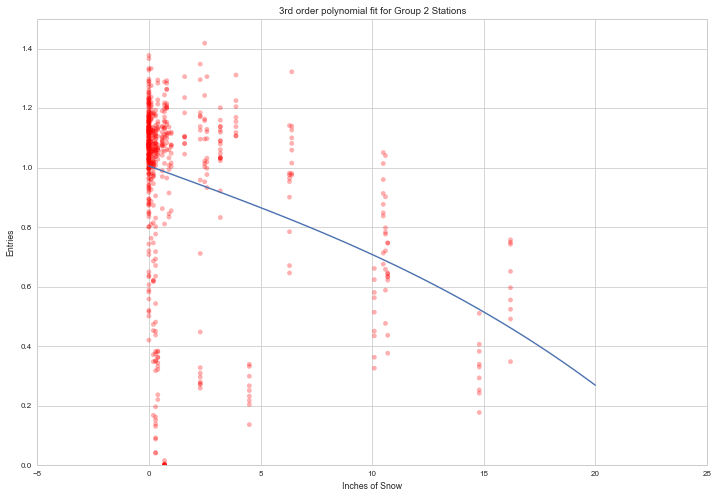

Percentage of ridership for 4.0404040404 inches of snow: 0.893263213194


In [189]:

xs=list([])
ys=list([])
plt.figure(figsize=(12,8))
plt.ylim([0,1.5])
print len(group_2_ids)


for station in group_2_ids:
    temp=snow_change(station,percent=True,plot=True,plot_type='scatter')
    
    #if(len(ys)==0):
    xs=xs+list(temp[0])
    ys=ys+list(temp[2])

def q_func(x,a,b,c,d):
    return a + b*x + c*x*x + d*x**3

x0=np.array([1.2,0,0,0])

fitted_params=optimization.curve_fit(q_func, xs, ys, x0)
print 'Parameters: '+str(fitted_params[0])
#fitted_params[0][0]

x_values=np.linspace(0,20,100)
y_values=q_func(x_values,fitted_params[0][0],fitted_params[0][1],fitted_params[0][2],fitted_params[0][3])

plt.plot(x_values,y_values)
plt.title('3rd order polynomial fit for Group 2 Stations')
plt.show()

print 'Percentage of ridership for '+str(x_values[20])+' inches of snow: '+str(y_values[20])

###Gaussian Stuff

[  3.2   0.4   0.    0.1   1.    0.1   0.6   0.7  10.1   0.    0.    0.2
   0.    0.    0.    2.6  10.5   0.9   6.3   0.3   0.    0.    0.    0.
   0.4   0.3   0.    6.4   0.3   0.   10.6   4.5   0.2   3.9   0.3   0.
   1.6  10.7   0.    0.1   3.2   0.1   2.5   0.    0.4   0.1   0.6   0.
   0.    0.    0.    0.    0.3   2.3   0.    0.3   0.    0.    0.2   0.
   0.2   0.    0.8   0.    2.3   0.2   0.7  16.2   0.    0.8  14.8   0.7]
[ 1.08148191  0.31954601  1.11774649  1.03002798  1.10616461  1.09363339
  1.08926645  1.06344455  0.4148592   1.00990209  1.08641845  1.10825315
  1.00306688  1.10635448  1.02471171  1.19046552  0.86370457  1.07768457
  1.02433197  1.06420402  0.9707895   1.21685702  1.07825417  0.97363751
  1.28862671  1.13350544  1.16426388  1.23679304  0.44656697  0.56979059
  0.95465082  0.26429474  1.06933043  1.25862774  0.62181413  1.18932632
  1.10122807  0.60320717  1.18856685  1.18268097  1.05831815  1.04066053
  1.13369531  1.0740771   1.1549604   1.13521425  1.15

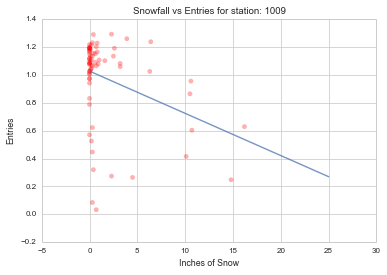

In [14]:
t=snow_change(1009,percent=True,plot_type='both')
print t[0]
print t[2]

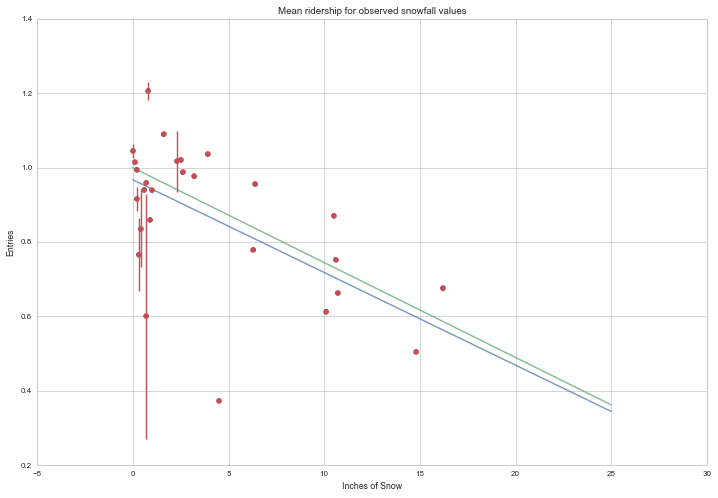

In [122]:

def temp_mean(x):
        return np.mean(x)
def temp_var(x):
    return np.var(x)

snowfall_vector=list([])
ride_vector=list([])
plt.figure(figsize=(12,8))

#using downtown and state st, high correlation
for stat in [1039,1077]:
    c=snow_change(stat,percent=True,plot_type='line')

    snowfall_vector+=list(c[0])
    ride_vector+=list(c[2])

d=pd.DataFrame(zip(snowfall_vector,ride_vector),columns=['snowfall','ridership'])
    
summary=d.groupby('snowfall').agg([temp_mean,temp_var,len])

## Remove snowdays

plt.title('Mean ridership for observed snowfall values')
plt.scatter(summary.index,summary['ridership']['temp_mean'])
plt.errorbar(summary.index,summary['ridership']['temp_mean'],yerr=summary['ridership']['temp_var'],fmt='o')

means=summary['ridership']['temp_mean']
var=summary['ridership']['temp_var']
num=summary['ridership']['len']

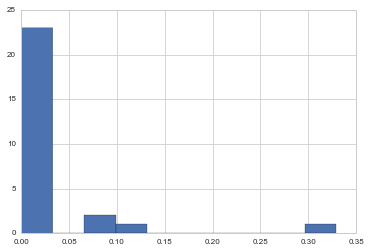

In [88]:
plt.hist(summary['ridership']['temp_var'])
plt.show()

In [125]:
snow_sample=pd.DataFrame(zip(summary.index,means,var,num),columns=['snowfall','mean','var','num_obs'])
snow_sample.to_csv('snow_sample.csv')

##Get time series for one station (day and multiple of same day)

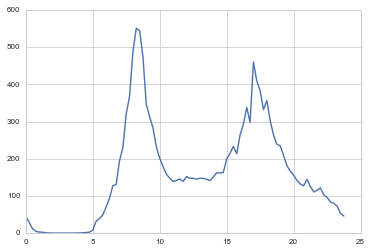

In [99]:
#Central square
t=gate_1315[gate_1315['locationid']==1036]
t=t[t['weekday']==1]
daily=t.groupby('servicetime_fraction').agg(np.mean)['entries']

plt.plot(daily.index,daily)
plt.show()

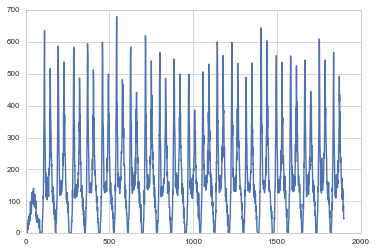

In [117]:
t=gate_1315[gate_1315['locationid']==1036]

#Tuesdays
t=t[t['weekday']==1]
t=t[t['servicedate']<'2013-06-01']
t2=t.groupby(['servicedate','servicetime_fraction']).agg(np.mean)

t2=t2.reset_index()

tuesdays=t2['entries']

plt.plot(t2.index,t2['entries'])
plt.show()

In [11]:
from sklearn.gaussian_process import GaussianProcess


In [28]:
#removing the datapoint with 22 inchese of snow as the model is very sensitive to it
# yet it is very uncharacteristic
snowfall=np.atleast_2d(c[0][:-1]).T
ridership=c[1][:-1]
variance=c[2][:-1]


[[ 1.]]


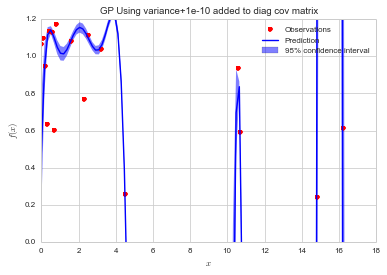

In [45]:

space = np.atleast_2d(np.linspace(0, 17, 100)).T

# Instantiate a Gaussian Process model
'''gp = GaussianProcess(regr='linear', theta0=1, thetaL=1e-5, thetaU=20,
                     random_start=100,nugget=1e-10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(snowfall, ridership)

print gp.theta_

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, MSE = gp.predict(space, eval_MSE=True)
sigma = np.sqrt(MSE)

fig = plt.figure(1, figsize=(8,5))
plt.subplot(121)
plt.plot(snowfall, ridership, 'r.', markersize=10, label=u'Observations')
plt.plot(space, y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([space, space[::-1]]),
        np.concatenate([y_pred - 1.9600 * sigma,
                       (y_pred + 1.9600 * sigma)[::-1]]),
        alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(0,1.2)
plt.legend(loc='upper right')
plt.title('GP Using 1e-10 added to diag cov matrix')
'''


##fit with variance of model+little additional to help deal with those points where variance==0
# Instantiate a Gaussian Process model
gp2 = GaussianProcess(regr='linear', theta0=1e-10, thetaL=1e-20, thetaU=1,
                     random_start=200,nugget=variance+1e-10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp2.fit(snowfall, ridership)

print gp2.theta_

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, MSE = gp2.predict(space, eval_MSE=True)
sigma = np.sqrt(MSE)

#plt.subplot(122)
plt.plot(snowfall, ridership, 'r.', markersize=10, label=u'Observations')
plt.plot(space, y_pred, 'b-', label=u'Prediction')
#plt.errorbar(snowfall,ridership,variance,fmt='none')
plt.fill(np.concatenate([space, space[::-1]]),
        np.concatenate([y_pred - 1.9600 * sigma,
                       (y_pred + 1.9600 * sigma)[::-1]]),
        alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(0,1.2)
plt.legend(loc='upper right')
plt.title('GP Using variance+1e-10 added to diag cov matrix')
plt.show()

In [ ]:
X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T

# Observations
y = f(X).ravel()

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x = np.atleast_2d(np.linspace(0, 10, 1000)).T

# Instanciate a Gaussian Process model
gp = GaussianProcess( theta0=1e-2, thetaL=1e-4, thetaU=1e-1,
                     random_start=100)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, MSE = gp.predict(x, eval_MSE=True)
sigma = np.sqrt(MSE)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
fig = pl.figure()
pl.plot(x, f(x), 'r:', label=u'$f(x) = x\,\sin(x)$')
pl.plot(X, y, 'r.', markersize=10, label=u'Observations')
pl.plot(x, y_pred, 'b-', label=u'Prediction')
pl.fill(np.concatenate([x, x[::-1]]),
        np.concatenate([y_pred - 1.9600 * sigma,
                       (y_pred + 1.9600 * sigma)[::-1]]),
        alpha=.5, fc='b', ec='None', label='95% confidence interval')
pl.xlabel('$x$')
pl.ylabel('$f(x)$')
pl.ylim(-10, 20)
pl.legend(loc='upper left')

##Gaussian Processes

In [23]:
from pymc.gp import *
from pymc.gp.cov_funs import matern


(-1.0, 0.99000000000000177, 2.4854009793906218, 3.9624679844736916)

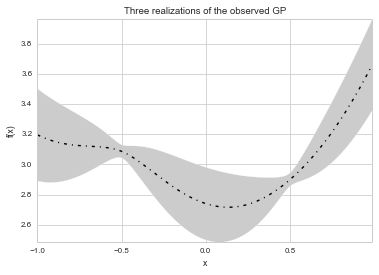

In [29]:
def quadfun(x, a, b, c):
    return (a * x ** 2 + b * x + c)

M = Mean(quadfun, a=1., b=.5, c=2.)
C = Covariance(
    eval_fun=matern.euclidean,
    diff_degree=1.4,
    amp=.4,
    scale=1.)

o = np.array([-.5, .5])
V = np.array([.002, .002])
data = np.array([3.1, 2.9])
observe(M, C, obs_mesh=o, obs_V=V, obs_vals=data)

# Generate realizations
f_list = [Realization(M, C) for i in range(3)]

x = np.arange(-1., 1., .01)

plot_envelope(M, C, mesh=x)

'''for f in f_list:
    plot(x, f(x))'''

xlabel('x')
ylabel('f(x)')
title('Three realizations of the observed GP')
axis('tight')